Type in the path to the CSV output by the FIJI plugin below, remembering to use \\\ to separate folders:

In [38]:
csv_path = "D:\\data\\HUVECs\\out\\2019-03-22 10-01-20 output\\output.csv";
experimental_condition = "MARCKSL1-EGFP";
control_condition = "EGFP";
string_to_determine_difference_from_file_name = "marcks";

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

def do_ttest(ax, category, vs):
    """add t-test to plot"""
    controls = np.array([v for v, cat in zip(vs, category) if not experimental_condition in cat])
    experiments = np.array([v for v, cat in zip(vs, category) if experimental_condition in cat])
    p = ttest_ind(controls, experiments).pvalue;
    start_ylims = ax.get_ylim();
    start_plot_height = ax.get_ylim()[1] - ax.get_ylim()[0];
    height_per_comparison = 0.1 * (start_ylims[1] - start_ylims[0]);
    ax.set_ylim(start_ylims[0], start_ylims[1] +  height_per_comparison);
    lx = ax.get_xticks()[0];
    rx = ax.get_xticks()[1];
    mid = lx/2 + rx/2;
    lry = start_ylims[1] + 0.5 * height_per_comparison;
    h = height_per_comparison/4;

    barx = [lx, lx, rx, rx];
    bary = [(lry-h), lry, lry, (lry-h)];
    ax.plot(barx, bary, c='black');
    ax.text(mid, lry + h/2, p_to_stars(p), horizontalalignment='center', fontsize=12);
    return p;

def format_p_value(p, decimal_places=3):
    """ensure p is printed with reasonable precision"""
    if p < 0.01:
        fmt_str = "{" + ":.{}E".format(decimal_places) + "}";
    else:
        fmt_str = "{" + ":.{}F".format(decimal_places) + "}";
    p_str = fmt_str.format(p);
    return p_str;

def p_to_stars(p):
    """map p-values to stars to display on graphs"""
    if p > 0.05:
        return 'n.s.';
    elif p > 0.01:
        return '*';
    elif p > 0.005:
        return '**';
    else:
        return '***';

First, load data and add column to identify control vs experimental conditions. Display first five lines. 

In [40]:
df = pd.read_csv(csv_path, encoding='cp1252');
df['Condition'] = [experimental_condition if string_to_determine_difference_from_file_name in t.lower() else control_condition for t in df['Image'].tolist()]
df.head()

,Image,ROI number,"Cell area, µm²","Cell perimeter, µm",Cell aspect ratio,Cell spikiness index,GFP channel mean,GFP channel SD,# nuclear centroids per cell,# nuclei fully enclosed per cell,Condition
0,EXP2 2dpt_slide 3_EGFP_1.tif,1,143.438750,46.729067,1.337751,1.035574,10967.142857,2205.598374,1,1,EGFP
1,EXP2 2dpt_slide 3_EGFP_1.tif,2,933.196875,244.654747,7.431514,1.087683,16000.152801,9039.244604,1,1,EGFP
2,EXP2 2dpt_slide 3_EGFP_1.tif,3,170.373125,52.769448,1.448859,1.055289,10886.259764,2380.856951,1,1,EGFP
3,EXP2 2dpt_slide 3_EGFP_1.tif,4,139.002500,45.809829,1.235261,1.039640,10015.481763,1559.338793,1,1,EGFP
4,EXP2 2dpt_slide 3_EGFP_1.tif,5,776.660625,186.377792,3.922218,1.225053,12613.394397,6880.293225,1,1,EGFP


For very crude quality control, include only cells that contain exactly one nucleus

In [41]:
prev_count = len(df);
df = df[df["# nuclei fully enclosed per cell"]==1];
print("Excluded {} cells based on number of enclosed nuclei".format(prev_count - len(df)));

Excluded 45 cells based on number of enclosed nuclei


Display plots comparing cell shape parameters for this data. 

Cell area, µm² control v experiment, p = 1.159E-19
Correlation between GFP intensity and Cell area, µm² in EGFP condition = 0.294
Correlation between GFP intensity and Cell area, µm² in MARCKSL1-EGFP condition = -9.512E-02
Cell spikiness index control v experiment, p = 0.014
Correlation between GFP intensity and Cell spikiness index in EGFP condition = 0.141
Correlation between GFP intensity and Cell spikiness index in MARCKSL1-EGFP condition = -4.570E-01
Cell aspect ratio control v experiment, p = 0.399
Correlation between GFP intensity and Cell aspect ratio in EGFP condition = 0.149
Correlation between GFP intensity and Cell aspect ratio in MARCKSL1-EGFP condition = -5.052E-03


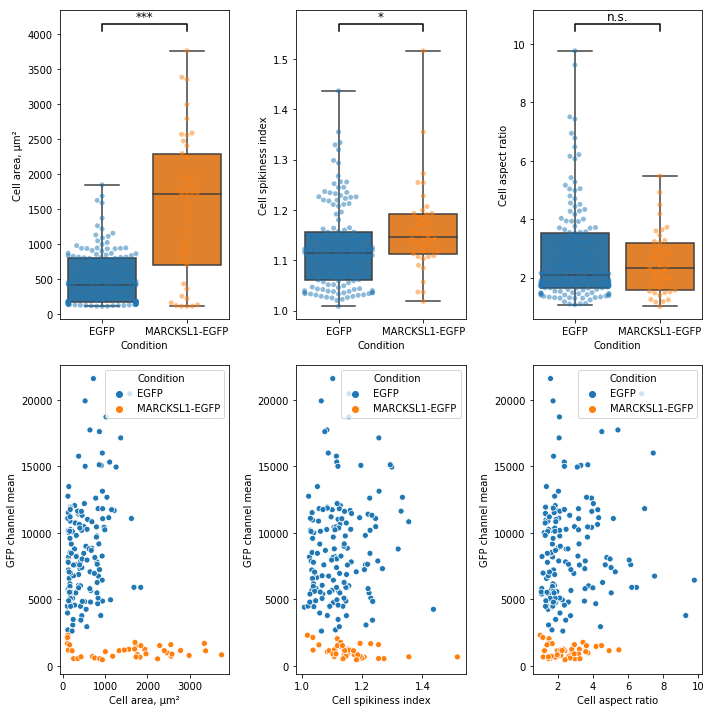

In [42]:
variable_list = ['Cell area, µm²', 'Cell spikiness index', 'Cell aspect ratio']
fig, axs = plt.subplots(nrows=2, ncols=len(variable_list), figsize=(10,10))

for idx, v in enumerate(variable_list):
    sns.boxplot(x='Condition', y=v, data=df, whis=np.Inf, ax=axs[0][idx]);
    p = do_ttest(axs[0][idx], df['Condition'].tolist(), df[v].tolist());
    sns.swarmplot(x='Condition', y=v, data=df, ax=axs[0][idx], alpha=0.5);
    sns.scatterplot(x=v, y='GFP channel mean', hue='Condition', data=df, ax=axs[1][idx])
    print("{} control v experiment, p = {}".format(v, format_p_value(p)));
    for condition in np.unique(df['Condition']):
        spr = df[df['Condition']==condition][v].corr(df[df['Condition']==condition]['GFP channel mean'], 'spearman');
        print("Correlation between GFP intensity and {} in {} condition = {}".format(v, 
                                                                                     condition, 
                                                                                     format_p_value(spr)))

plt.tight_layout();